In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/FPRDataset
clear_output()

In [ ]:
print("Train Nodule:",len(os.listdir("/content/gdrive/MyDrive/FPRDataset/train/nodule")))
print("Train Non-Nodule:",len(os.listdir("/content/gdrive/MyDrive/FPRDataset/train/non-nodule")))
print("Test Nodule:",len(os.listdir("/content/gdrive/MyDrive/FPRDataset/test/nodule")))
print("Test Non-Nodule:",len(os.listdir("/content/gdrive/MyDrive/FPRDataset/test/non-nodule")))

Train Nodule: 506
Train Non-Nodule: 5159
Test Nodule: 169
Test Non-Nodule: 2465


In [ ]:
BATCH_SIZE = 96
generator = ImageDataGenerator(rescale=1./255)
trainData = generator.flow_from_directory(
    "/content/gdrive/MyDrive/FPRDataset/train",
    target_size=(50,50),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)
testData = generator.flow_from_directory(
    "/content/gdrive/MyDrive/FPRDataset/test",
    target_size=(50,50),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)

Found 5665 images belonging to 2 classes.
Found 2634 images belonging to 2 classes.


In [ ]:
print(trainData.class_indices)
print(testData.class_indices)

{'nodule': 0, 'non-nodule': 1}
{'nodule': 0, 'non-nodule': 1}


In [ ]:
weight_path="checkpoint-{epoch:03d}-{val_loss:.3f}.hdf5"
modelcheckpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import AveragePooling2D

In [ ]:
def dense_block(x, growth_rate, filters):
    """
    Defines a Dense Block for the DenseNet architecture.

    Args:
        x: Input tensor.
        growth_rate: Number of filters to add per layer within the block.
        filters: Number of filters in the current layer.

    Returns:
        Output tensor of the Dense Block.
    """

    for _ in range(4):
        out = tf.keras.layers.BatchNormalization()(x)
        out = tf.keras.layers.ReLU()(out)
        out = tf.keras.layers.Conv2D(growth_rate, (3, 3), padding="same")(out)
        filters += growth_rate
        x = tf.keras.layers.concatenate([x, out])
    return x, filters

In [ ]:
def transition_layer(x, filters):
    """
    Defines a Transition Layer for downsampling the feature maps.

    Args:
        x: Input tensor.
        filters: Number of filters in the current layer.

    Returns:
        Output tensor of the Transition Layer.
    """

    out = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv2D(filters, (1, 1), use_bias=False)(out)
    out = tf.keras.layers.AveragePooling2D((2, 2), strides=2)(out)
    return out


In [ ]:
def build_model(input_shape=(50, 50, 1), num_classes=1):
    """
    Builds the DenseNet architecture for lung nodule detection.

    Args:
        input_shape: Shape of the input images.
        num_classes: Number of output classes.

    Returns:
        A compiled Keras model.
    """

    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding="same")(inputs)

    # Dense blocks and transition layers
    filters = 64
    x, filters = dense_block(x, 32, filters)
    x = transition_layer(x, filters // 2)

    x, filters = dense_block(x, 32, filters)
    x = transition_layer(x, filters // 2)

    # Global average pooling and output layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Example usage
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 25, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 25, 25, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 25, 25, 64)   0           ['batch_normalization[0][0]']

In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit_generator(
        trainData,
        epochs=100,
        validation_data=testData,
        verbose=1,
        callbacks=[modelcheckpoint],
    )

<ipython-input-13-48a84d63610b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.9049 
Epoch 1: val_loss improved from inf to 0.37612, saving model to checkpoint-001-0.376.hdf5
60/60 [==============================] - 1927s 32s/step - loss: 0.3221 - accuracy: 0.9049 - val_loss: 0.3761 - val_accuracy: 0.9358
Epoch 2/100
59/60 [============================>.] - ETA: 0s - loss: 0.2914 - accuracy: 0.9107
Epoch 2: val_loss improved from 0.37612 to 0.25063, saving model to checkpoint-002-0.251.hdf5
60/60 [==============================] - 37s 622ms/step - loss: 0.2914 - accuracy: 0.9107 - val_loss: 0.2506 - val_accuracy: 0.9358
Epoch 3/100
60/60 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.9109
Epoch 3: val_loss did not improve from 0.25063
60/60 [==============================] - 38s 636ms/step - loss: 0.2864 - accuracy: 0.9109 - val_loss: 0.2954 - val_accuracy: 0.9358
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 0.2722 - accuracy:

Final Accuracy: 1.0


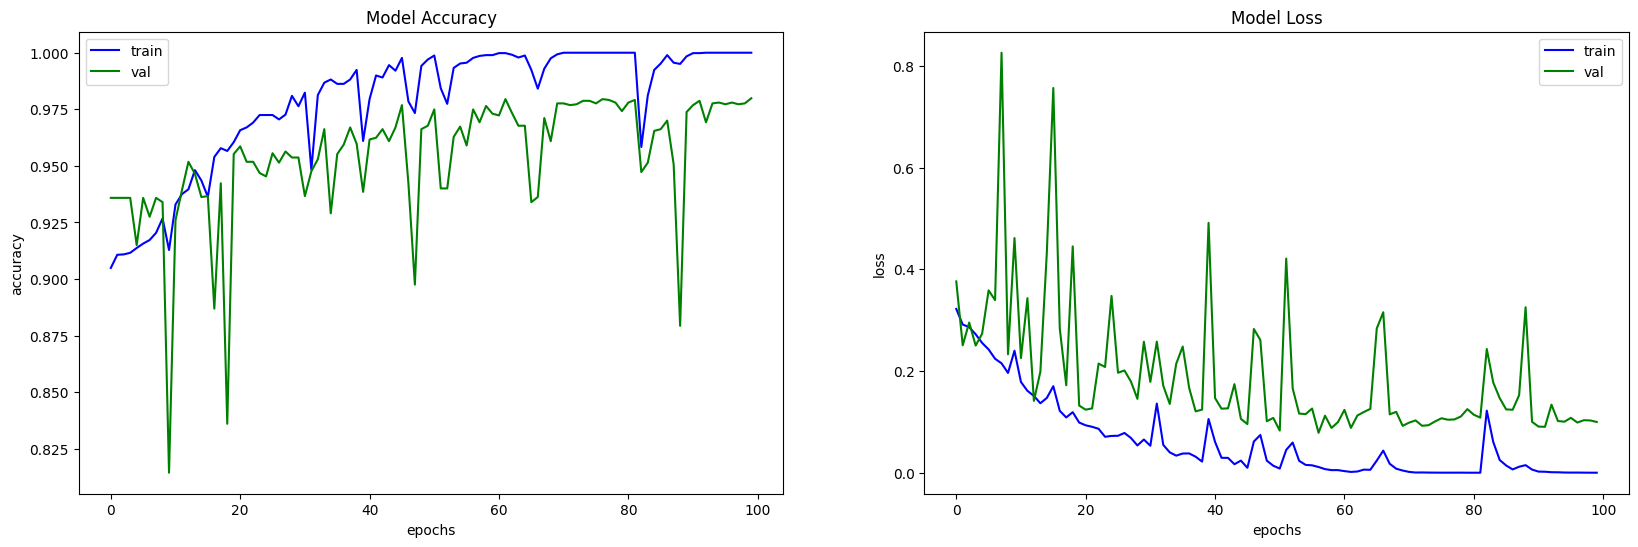

In [ ]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['accuracy', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

final_accuracy = history.history['accuracy'][-1]
print("Final Accuracy:", final_accuracy)
plt.show()

In [ ]:
model.save("/content/gdrive/MyDrive/Training_logs/model2.h5")

In [ ]:
model2 = build_model()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.load_weights("/content/checkpoint-057-0.079.hdf5")
model2.save("checkpoint_model2.h5")

In [ ]:
!cp checkpoint_model2.h5 /content/gdrive/MyDrive/Training_logs/best_checkpoint_model2.h5